<a href="https://colab.research.google.com/github/im-karthikrajesh/customer-analytics-and-segmentation/blob/colab/Customer_Analytics_and_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Customer Analytics and Segmentation**

In [ ]:
# Import the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA
from tabulate import tabulate

**1. Data Loading and Inspection**

In [ ]:
!wget -O asa_cw1_data.zip "https://drive.google.com/uc?export=download&id=1E17e_pf7mu7_cYYh1SaqaOlLPi7jydYR"
!unzip asa_cw1_data.zip

--2025-03-06 18:47:54--  https://drive.google.com/uc?export=download&id=1E17e_pf7mu7_cYYh1SaqaOlLPi7jydYR
Resolving drive.google.com (drive.google.com)... 74.125.196.139, 74.125.196.100, 74.125.196.138, ...
Connecting to drive.google.com (drive.google.com)|74.125.196.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1E17e_pf7mu7_cYYh1SaqaOlLPi7jydYR&export=download [following]
--2025-03-06 18:47:54--  https://drive.usercontent.google.com/download?id=1E17e_pf7mu7_cYYh1SaqaOlLPi7jydYR&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 74.125.134.132, 2607:f8b0:400c:c00::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|74.125.134.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14111474 (13M) [application/octet-stream]
Saving to: ‘asa_cw1_data.zip’

asa_cw1_data.zip    100%[===================>]  13.46M  54.3MB

In [ ]:
def read_csv(filepath):
    try:
        df = pd.read_csv(filepath)
        print(f"Successfully loaded {filepath}")
        return df
    except FileNotFoundError as e:
        print(f"[Error] File not found: {filepath}. Please check the path.")
        raise e
    except pd.errors.EmptyDataError as e:
        print(f"[Error] CSV file is empty or invalid: {filepath}.")
        raise e

In [ ]:
# Load the data
filename1 = "asa_cw1_data/customers_sample.csv"
filename2 = "asa_cw1_data/category_spends_sample.csv"
filename3 = "asa_cw1_data/baskets_sample.csv"
filename4 = "asa_cw1_data/lineitems_sample.csv"

In [ ]:
customers = read_csv(filename1)
category_spends = read_csv(filename2)
baskets = read_csv(filename3)
lineitems = read_csv(filename4)

Successfully loaded asa_cw1_data/customers_sample.csv
Successfully loaded asa_cw1_data/category_spends_sample.csv
Successfully loaded asa_cw1_data/baskets_sample.csv
Successfully loaded asa_cw1_data/lineitems_sample.csv


In [ ]:
# Print basic information about the datasets
data_info = [
    ["Customers", customers.shape],
    ["Category Spends", category_spends.shape],
    ["Baskets", baskets.shape],
    ["Line Items", lineitems.shape]
]

print(tabulate(data_info, headers=["Dataset", "Shape"], tablefmt="psql"))

+-----------------+--------------+
| Dataset         | Shape        |
|-----------------+--------------|
| Customers       | (3000, 6)    |
| Category Spends | (3000, 21)   |
| Baskets         | (195547, 5)  |
| Line Items      | (1461315, 6) |
+-----------------+--------------+


In [ ]:
# Function to display dataset info
def display_dataset_info(name, df):
    print(f"\n{'='*10} {name} {'='*10}\n")

    # Display a preview of the dataset
    print("Preview of the dataset:")
    print(tabulate(df.head(), headers='keys', tablefmt='grid'))

    # Display dataset info
    print("\n Dataset Info:")
    print(df.info())

    # Check for missing values
    print("\nMissing Values:")
    print(df.isna().sum())

# Display info for each dataset
display_dataset_info("Customers Dataset", customers)
display_dataset_info("Category Spends Dataset", category_spends)
display_dataset_info("Baskets Dataset", baskets)
display_dataset_info("Line Items Dataset", lineitems)



========== Customers Dataset ==========

Preview of the dataset:
+----+-------------------+-----------+------------------+--------------------+---------------+-----------------+
|    |   customer_number |   baskets |   total_quantity |   average_quantity | total_spend   | average_spend   |
+====+===================+===========+==================+====================+===============+=================+
|  0 |              4749 |       220 |              260 |            1.18182 | £631.12       | £2.87           |
+----+-------------------+-----------+------------------+--------------------+---------------+-----------------+
|  1 |              4757 |       248 |              333 |            1.34274 | £452.42       | £1.82           |
+----+-------------------+-----------+------------------+--------------------+---------------+-----------------+
|  2 |               144 |       226 |              303 |            1.34071 | £261.16       | £1.16           |
+----+-------------------+----

**2. Data Cleaning & Formatting**

In [ ]:
# Function to convert currency strings to floats.
def convert_currency(x):
    if isinstance(x, str):
        try:
            return float(x.replace("£", "").replace(",", "").strip())
        except ValueError:
            return np.nan
    return x

# Remove rows where any column in 'cols' is negative.
def remove_negative(df, cols):
    for c in cols:
        df = df[df[c] >= 0]
    return df

# --- Clean baskets_sample.csv ---
# Convert purchase_time to datetime for time-based analysis
baskets['purchase_time'] = pd.to_datetime(baskets['purchase_time'])
# Remove currency symbols in 'basket_spend'
baskets['basket_spend'] = baskets['basket_spend'].apply(convert_currency)

# --- Clean category_spends_sample.csv ---
# Convert all spend columns (except 'customer_number') to float
for col in category_spends.columns:
    if col != "customer_number":
        category_spends[col] = category_spends[col].apply(convert_currency)

# --- Clean customers_sample.csv ---
# Convert 'total_spend' and 'average_spend' to float
customers['total_spend'] = customers['total_spend'].apply(convert_currency)
customers['average_spend'] = customers['average_spend'].apply(convert_currency)

# --- Clean lineitems_sample.csv ---
# Convert 'purchase_time' to datetime and remove currency symbols in 'spend'
lineitems['purchase_time'] = pd.to_datetime(lineitems['purchase_time'])
lineitems['spend'] = lineitems['spend'].apply(convert_currency)

In [ ]:
# --- Remove Erroneous Negative Values ---
# Customers: remove negative 'total_spend' or 'average_spend'
orig_customers = customers.shape[0]
customers = remove_negative(customers, ['total_spend', 'average_spend'])
print(f"Customers: {orig_customers} rows originally, now {customers.shape[0]} rows after removing negatives.")

# Baskets: remove negative 'basket_spend'
orig_baskets = baskets.shape[0]
baskets = baskets[baskets['basket_spend'] >= 0]
print(f"Baskets: {orig_baskets} rows originally, now {baskets.shape[0]} rows after removing negatives.")

# Line Items: remove negative 'spend' or 'quantity'
orig_lineitems = lineitems.shape[0]
lineitems = lineitems[(lineitems['spend'] >= 0) & (lineitems['quantity'] >= 0)]
print(f"Line Items: {orig_lineitems} rows originally, now {lineitems.shape[0]} rows after removing negatives.")

# Category Spends: remove rows if any spend column (except 'customer_number') is negative
orig_cat_spends = category_spends.shape[0]
spend_cols = [col for col in category_spends.columns if col != 'customer_number']
category_spends = category_spends[(category_spends[spend_cols] >= 0).all(axis=1)]
print(f"Category Spends: {orig_cat_spends} rows originally, now {category_spends.shape[0]} rows after removing negatives.")

Customers: 3000 rows originally, now 3000 rows after removing negatives.
Baskets: 195547 rows originally, now 195387 rows after removing negatives.
Line Items: 1461315 rows originally, now 1460451 rows after removing negatives.
Category Spends: 3000 rows originally, now 2971 rows after removing negatives.


In [ ]:
# Correcting the "bakery" column from lineitems ('bakery' in category_spends was inaccurate)
bakery_spend_df = (
    lineitems[lineitems['category'] == 'BAKERY']
    .groupby('customer_number')['spend'].sum()
    .reset_index(name='bakery_corrected')
)

# Merge 'bakery_corrected' into category_spends and replace old bakery values
category_spends = category_spends.merge(bakery_spend_df, on='customer_number', how='left')
category_spends['bakery_corrected'] = category_spends['bakery_corrected'].fillna(0)
category_spends['bakery'] = category_spends['bakery_corrected']
category_spends.drop(columns='bakery_corrected', inplace=True)

**3. Verify Cleaning**

In [ ]:
# Function to display summary statistics
def display_summary_stats(title, df, cols):
    print(f"\n{'='*15} {title} {'='*15}\n")
    print("Summary Statistics:")
    print(tabulate(df[cols].describe(), headers='keys', tablefmt='grid'))

# Function to display dataset preview
def display_dataset_preview(title, df):
    print(f"\n{'='*15} {title} {'='*15}\n")
    print("Preview of the dataset:")
    print(tabulate(df.head(), headers='keys', tablefmt='grid'))

# Verify Cleaning
# Customers Spend Summary
display_summary_stats("Customers Spend Summary", customers, ['total_spend', 'average_spend'])

# Baskets Spend Summary
display_summary_stats("Baskets Spend Summary", baskets, ['basket_spend'])

# Category Spends Summary (Excluding Identifier)
display_summary_stats("Category Spends Summary", category_spends, spend_cols)

# Line Items Summary
display_summary_stats("Line Items Summary", lineitems, ['spend', 'quantity'])

# Preview of the cleaned datasets
display_dataset_preview("Cleaned Customers Data", customers)
display_dataset_preview("Cleaned Baskets Data", baskets)
display_dataset_preview("Cleaned Category Spends Data", category_spends)
display_dataset_preview("Cleaned Line Items Data", lineitems)


=============== Customers Spend Summary ===============

Summary Statistics:
+-------+---------------+-----------------+
|       |   total_spend |   average_spend |
+=======+===============+=================+
| count |      3000     |     3000        |
+-------+---------------+-----------------+
| mean  |       769.413 |        1.68248  |
+-------+---------------+-----------------+
| std   |       552.769 |        0.733105 |
+-------+---------------+-----------------+
| min   |         7.28  |        0.62     |
+-------+---------------+-----------------+
| 25%   |       406.12  |        1.26     |
+-------+---------------+-----------------+
| 50%   |       627.17  |        1.49     |
+-------+---------------+-----------------+
| 75%   |       957.675 |        1.86     |
+-------+---------------+-----------------+
| max   |      6588.65  |       10.84     |
+-------+---------------+-----------------+

=============== Baskets Spend Summary ===============

Summary Statistics:
+-------+-

 **4. Exploratory Data Analysis (EDA)**

In [ ]:
# Descriptive Statistics
def display_descriptive_stats(title, df):
    numeric_cols = df.select_dtypes(include=[np.number])
    if numeric_cols.empty:
        print(f"\nNo numeric columns to describe for {title}.")
        return

    desc = numeric_cols.describe()
    desc_table = tabulate(desc, headers='keys', tablefmt='psql')
    print(f"\n=== Descriptive Statistics: {title} ===")
    print(desc_table)

print("\n--- DESCRIPTIVE STATISTICS ---")

display_descriptive_stats("Customers Dataset", customers)
display_descriptive_stats("Category Spends Dataset", category_spends)
display_descriptive_stats("Baskets Dataset", baskets)
display_descriptive_stats("Line Items Dataset", lineitems)


--- DESCRIPTIVE STATISTICS ---

=== Descriptive Statistics: Customers Dataset ===
+-------+-------------------+-----------+------------------+--------------------+---------------+-----------------+
|       |   customer_number |   baskets |   total_quantity |   average_quantity |   total_spend |   average_spend |
|-------+-------------------+-----------+------------------+--------------------+---------------+-----------------|
| count |           3000    |  3000     |         3000     |        3000        |      3000     |     3000        |
| mean  |           8095.72 |   487.105 |          583.722 |           1.2045   |       769.413 |        1.68248  |
| std   |           4686.26 |   332.825 |          405.006 |           0.136323 |       552.769 |        0.733105 |
| min   |             14    |     6     |            6     |           1        |         7.28  |        0.62     |
| 25%   |           4044.75 |   257     |          307.75  |           1.11963  |       406.12  |        

<Figure size 1200x800 with 0 Axes>

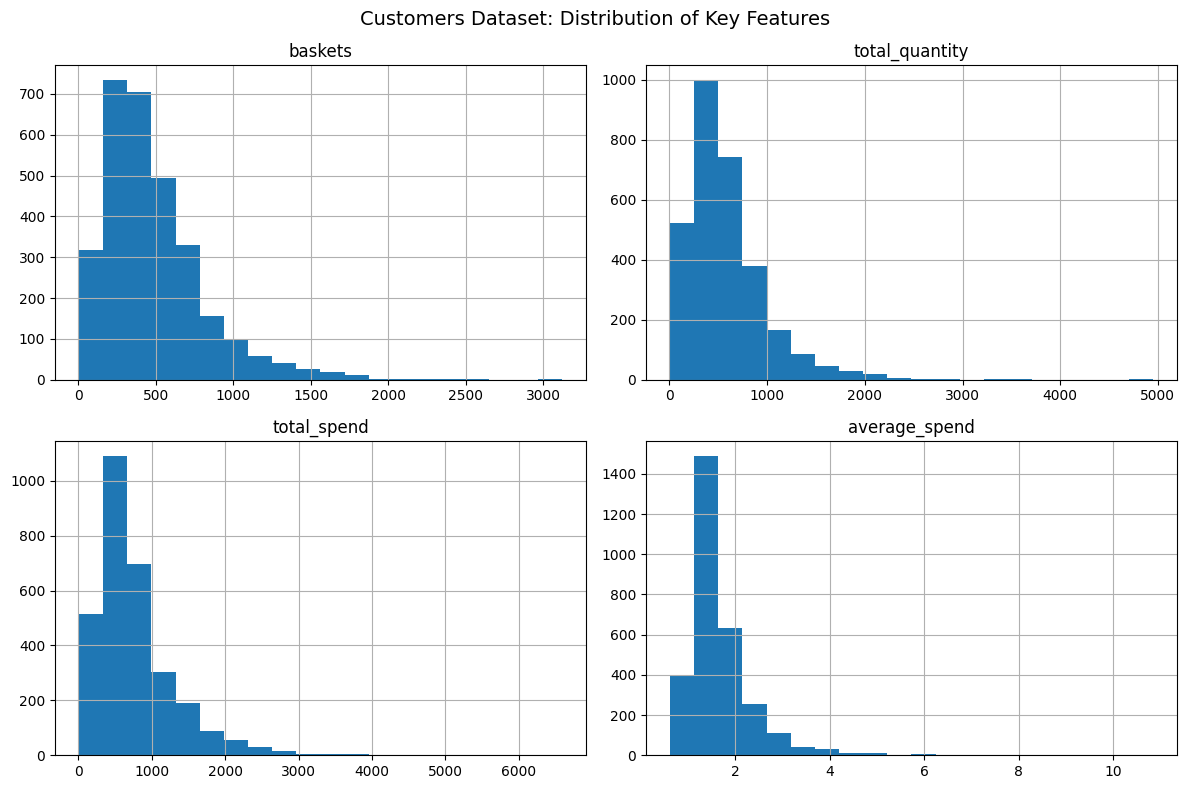

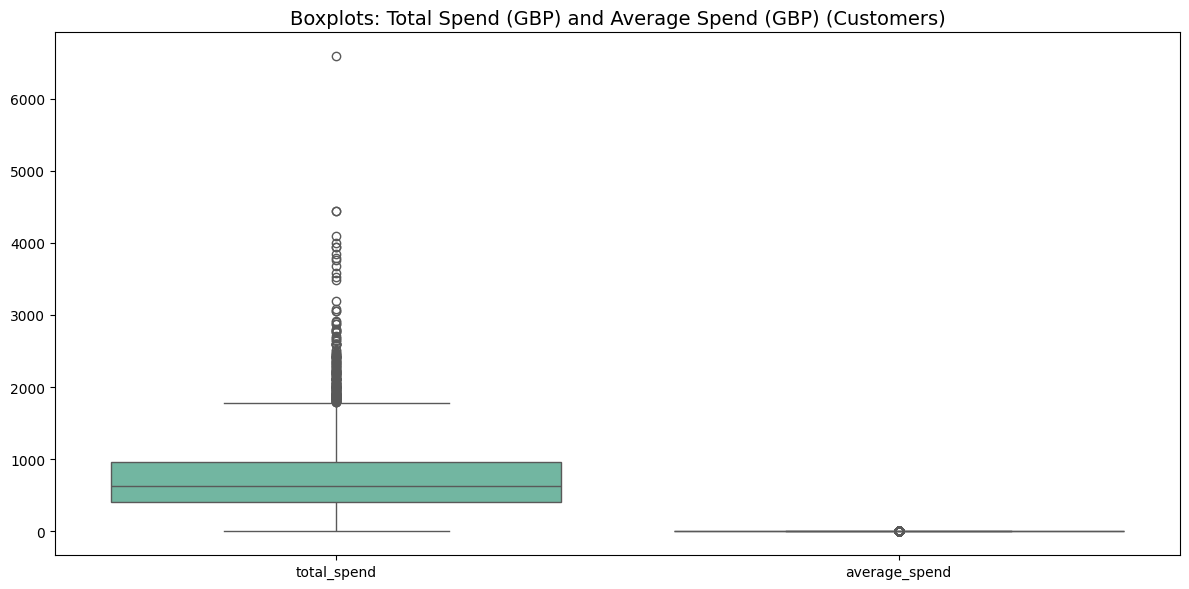

+---------------+--------------+-----------------------------------------+
| Feature       |   Skew Value | Recommendation                          |
|---------------+--------------+-----------------------------------------|
| total_spend   |         2.23 | Highly skewed, apply log transformation |
| average_spend |         3.43 | Highly skewed, apply log transformation |
+---------------+--------------+-----------------------------------------+


In [ ]:
# Distribution Analysis: Histograms & Boxplots

# Customers dataset distributions
plt.figure(figsize=(12, 8))
customers[['baskets', 'total_quantity', 'total_spend', 'average_spend']].hist(bins=20, figsize=(12, 8))
plt.suptitle("Customers Dataset: Distribution of Key Features", fontsize=14)
plt.tight_layout()
plt.show()

# Boxplots for customers
plt.figure(figsize=(12, 6))
sns.boxplot(data=customers[['total_spend', 'average_spend']], palette="Set2")
plt.title("Boxplots: Total Spend (GBP) and Average Spend (GBP) (Customers)", fontsize=14)
plt.tight_layout()
plt.show()

def report_skew(df, col, threshold=1):
    skew_val = df[col].skew()
    if abs(skew_val) > threshold:
        recommendation = "Highly skewed, apply log transformation"
    else:
        recommendation = "Skew acceptable"
    return [col, f"{skew_val:.2f}", recommendation]

# Features to check
features_to_check = ['total_spend', 'average_spend']
results = [report_skew(customers, col) for col in features_to_check]

print(tabulate(results, headers=["Feature", "Skew Value", "Recommendation"], tablefmt="psql"))

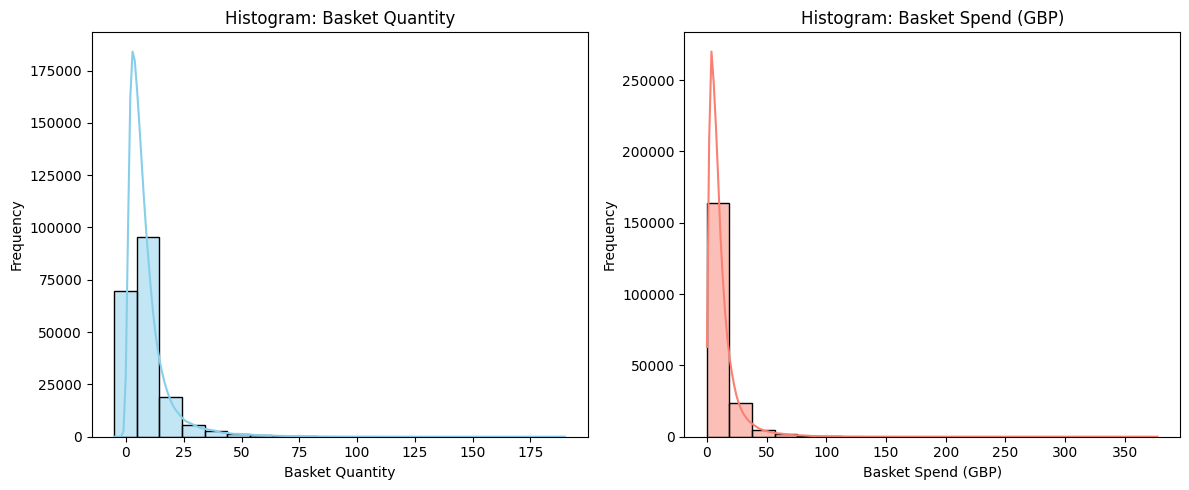

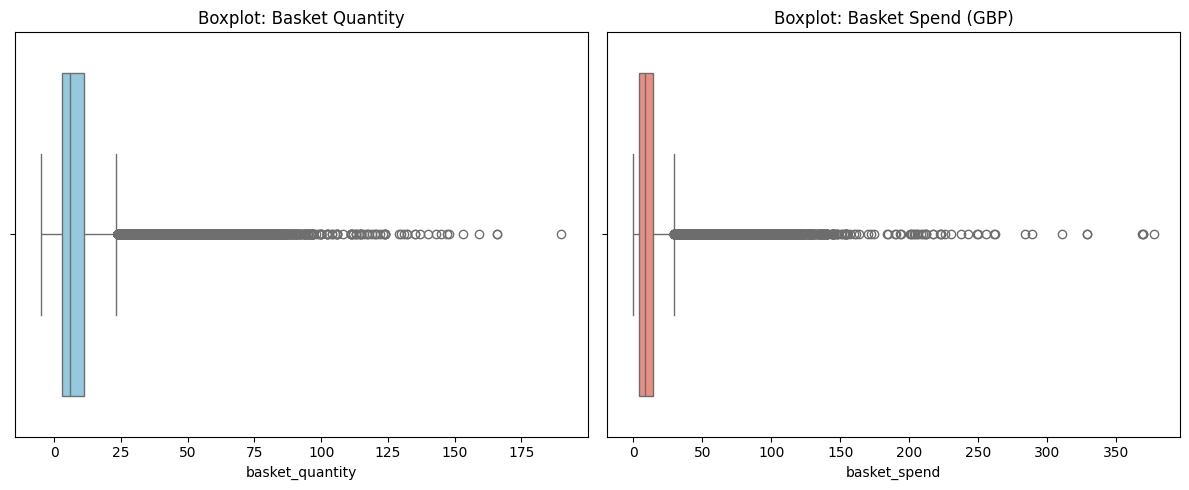

In [ ]:
# Baskets dataset: basket_quantity and basket_spend
plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
sns.histplot(baskets['basket_quantity'], bins=20, kde=True, color='skyblue')
plt.title("Histogram: Basket Quantity", fontsize=12)
plt.xlabel("Basket Quantity")
plt.ylabel("Frequency")

plt.subplot(1,2,2)
sns.histplot(baskets['basket_spend'], bins=20, kde=True, color='salmon')
plt.title("Histogram: Basket Spend (GBP)", fontsize=12)
plt.xlabel("Basket Spend (GBP)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Boxplots for baskets
plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
sns.boxplot(x=baskets['basket_quantity'], color='skyblue')
plt.title("Boxplot: Basket Quantity", fontsize=12)

plt.subplot(1,2,2)
sns.boxplot(x=baskets['basket_spend'], color='salmon')
plt.title("Boxplot: Basket Spend (GBP)", fontsize=12)
plt.tight_layout()
plt.show()

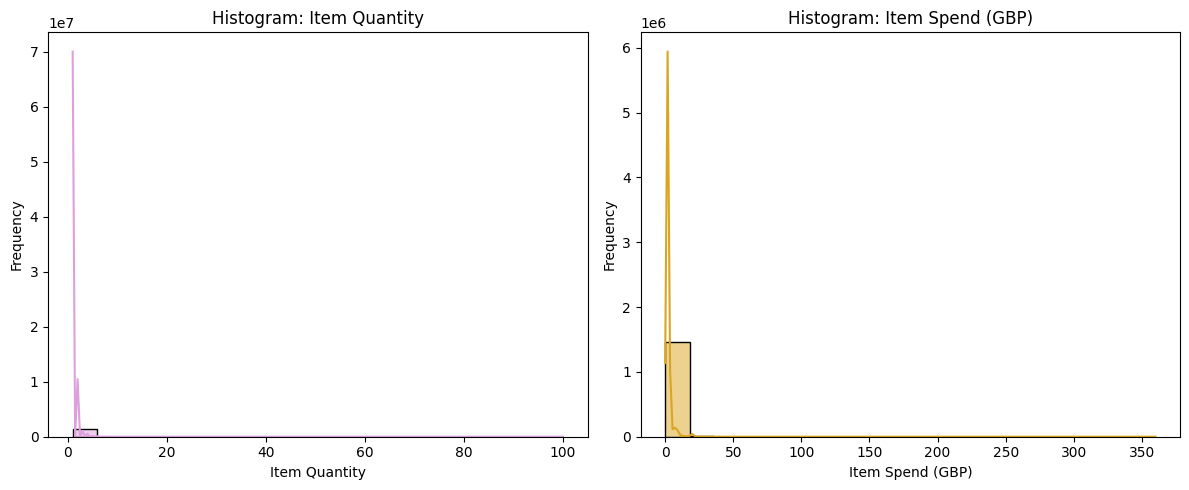

In [ ]:
# Line Items dataset: quantity and spend
plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
sns.histplot(lineitems['quantity'], bins=20, kde=True, color='plum')
plt.title("Histogram: Item Quantity", fontsize=12)
plt.xlabel("Item Quantity")
plt.ylabel("Frequency")

plt.subplot(1,2,2)
sns.histplot(lineitems['spend'], bins=20, kde=True, color='goldenrod')
plt.title("Histogram: Item Spend (GBP)", fontsize=12)
plt.xlabel("Item Spend (GBP)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

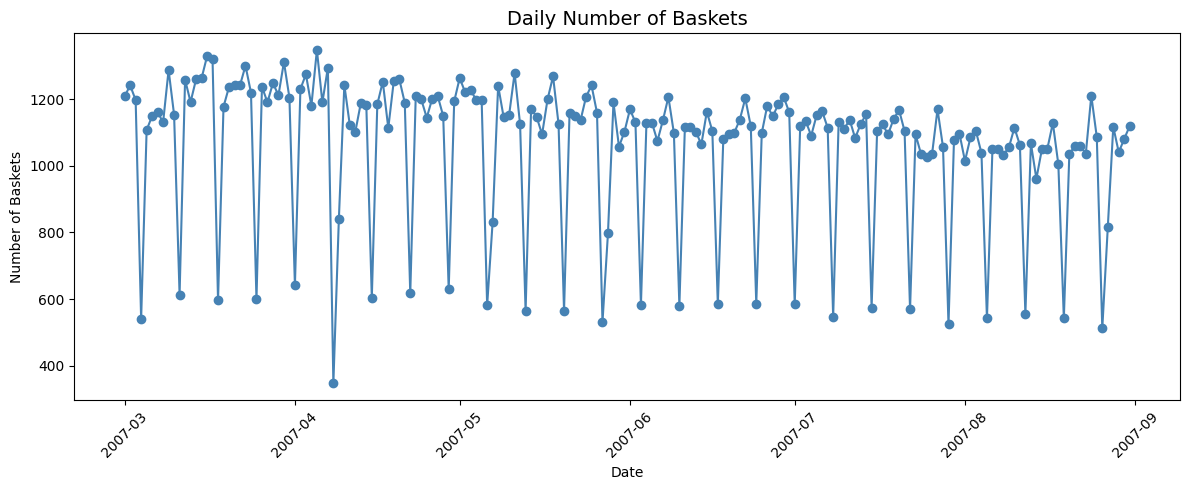

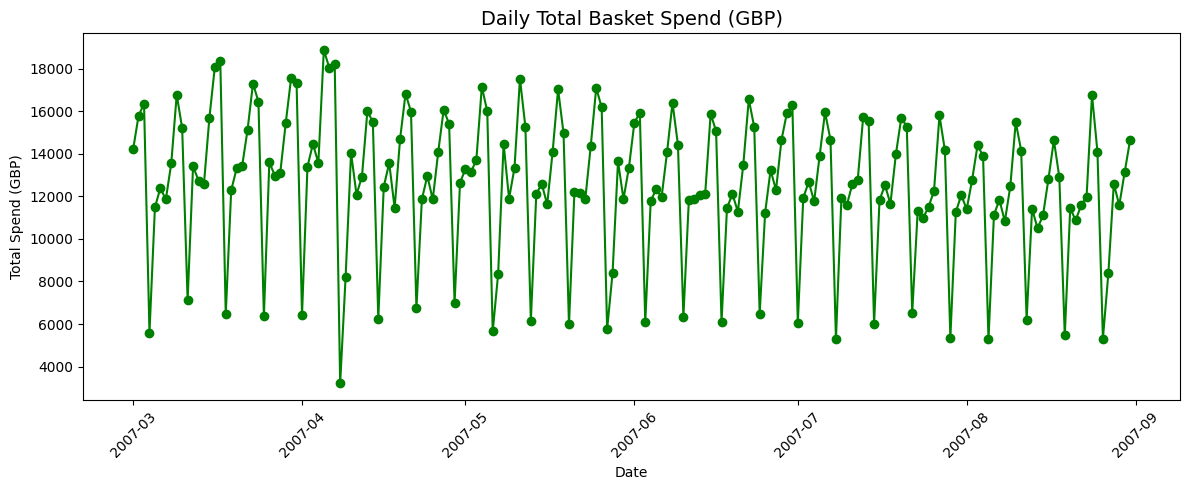

In [ ]:
# Time-Series Analysis (Baskets)
baskets['date'] = baskets['purchase_time'].dt.date
daily_baskets = baskets.groupby('date').size()
daily_spend = baskets.groupby('date')['basket_spend'].sum()

plt.figure(figsize=(12, 5))
plt.plot(daily_baskets.index, daily_baskets.values, marker='o', color='steelblue')
plt.title("Daily Number of Baskets", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Number of Baskets")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(daily_spend.index, daily_spend.values, marker='o', color='green')
plt.title("Daily Total Basket Spend (GBP)", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Total Spend (GBP)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<ipython-input-17-ecb16bd5f1fb>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cat_total.index, y=cat_total.values, palette='viridis')


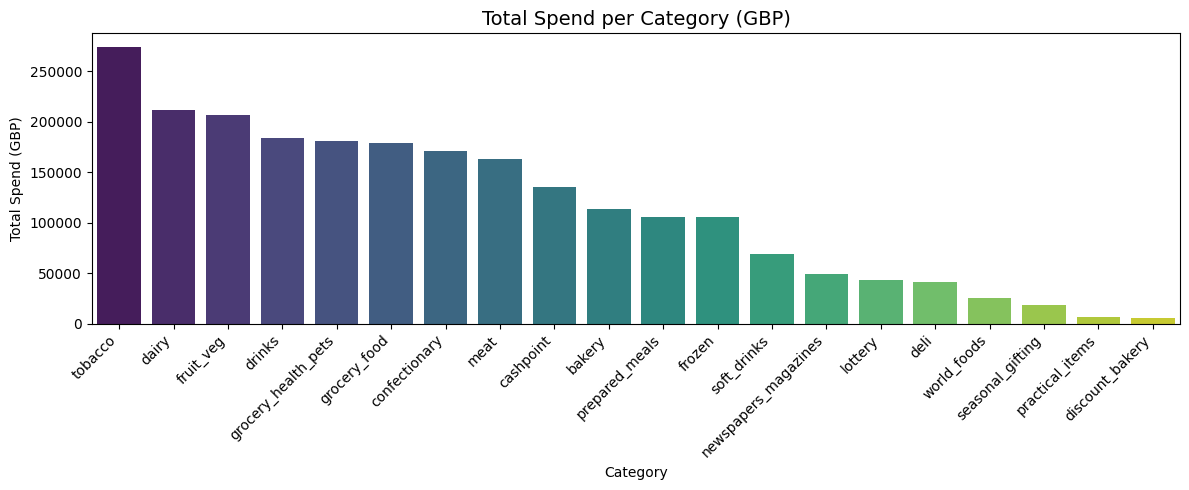

<ipython-input-17-ecb16bd5f1fb>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cat_avg.index, y=cat_avg.values, palette='magma')


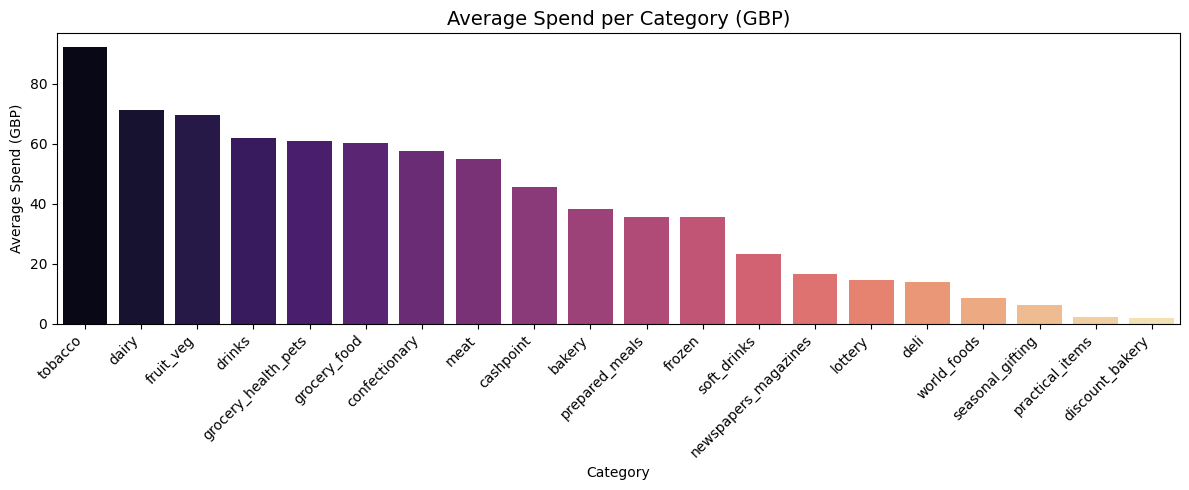


--- Line Items Category-Level Summary ---
+----------------------+------------+-----------+---------------------+
| category             |   quantity |     spend |   transaction_count |
|----------------------+------------+-----------+---------------------|
| FRUIT_VEG            |     215955 | 208368    |              200880 |
| DAIRY                |     224304 | 213908    |              184139 |
| CONFECTIONARY        |     215844 | 172078    |              171321 |
| GROCERY_FOOD         |     201777 | 180023    |              164854 |
| GROCERY_HEALTH_PETS  |     150835 | 182740    |              123195 |
| BAKERY               |     133725 | 114630    |              114874 |
| NEWSPAPERS_MAGAZINES |      76944 |  49960.2  |               74733 |
| PREPARED_MEALS       |      78109 | 106442    |               64722 |
| SOFT_DRINKS          |      82090 |  69927.7  |               60711 |
| FROZEN               |      69082 | 106398    |               59106 |
| MEAT               

<ipython-input-17-ecb16bd5f1fb>:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=lineitem_cat.index, y=lineitem_cat['transaction_count'], palette='coolwarm')


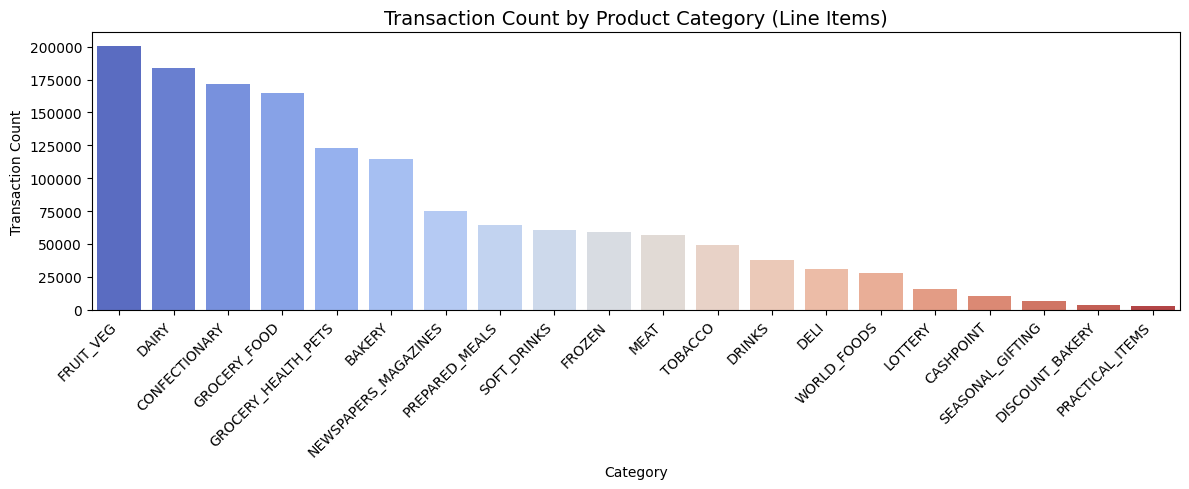

In [ ]:
# Category-Level Insights
# For category_spends: total and average spend per category
cat_total = category_spends[spend_cols].sum().sort_values(ascending=False)
cat_avg = category_spends[spend_cols].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 5))
sns.barplot(x=cat_total.index, y=cat_total.values, palette='viridis')
plt.title("Total Spend per Category (GBP)", fontsize=14)
plt.xlabel("Category")
plt.ylabel("Total Spend (GBP)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))
sns.barplot(x=cat_avg.index, y=cat_avg.values, palette='magma')
plt.title("Average Spend per Category (GBP)", fontsize=14)
plt.xlabel("Category")
plt.ylabel("Average Spend (GBP)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# For lineitems: Analyze product-level spending frequency per category
lineitem_cat = lineitems.groupby('category').agg({
    'quantity': 'sum',
    'spend': 'sum',
    'product_id': 'count'
}).rename(columns={'product_id': 'transaction_count'}).sort_values(by='transaction_count', ascending=False)

print("\n--- Line Items Category-Level Summary ---")

lineitem_cat_table = tabulate(lineitem_cat, headers='keys', tablefmt='psql')
print(lineitem_cat_table)

plt.figure(figsize=(12, 5))
sns.barplot(x=lineitem_cat.index, y=lineitem_cat['transaction_count'], palette='coolwarm')
plt.title("Transaction Count by Product Category (Line Items)", fontsize=14)
plt.xlabel("Category")
plt.ylabel("Transaction Count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

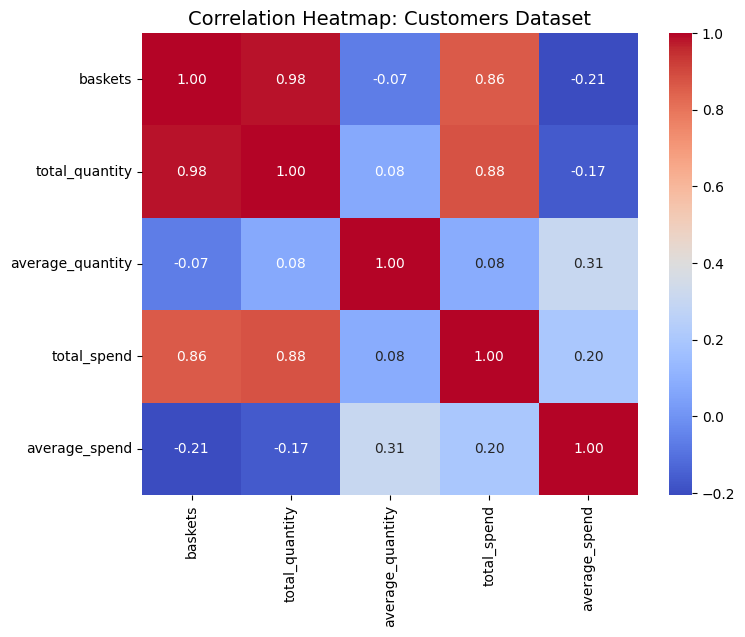

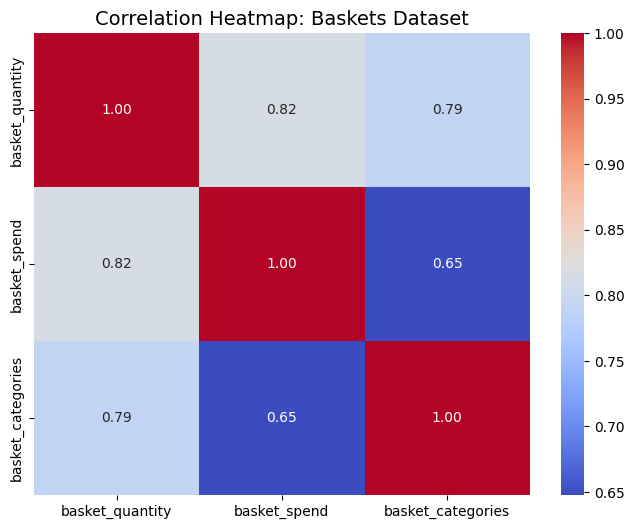

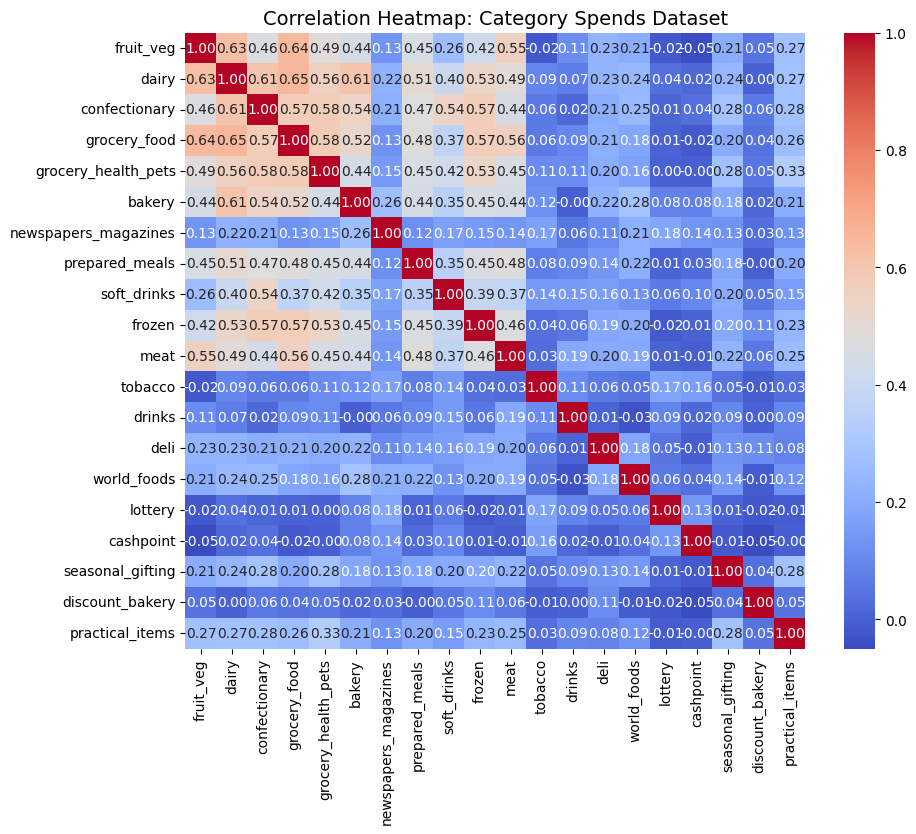

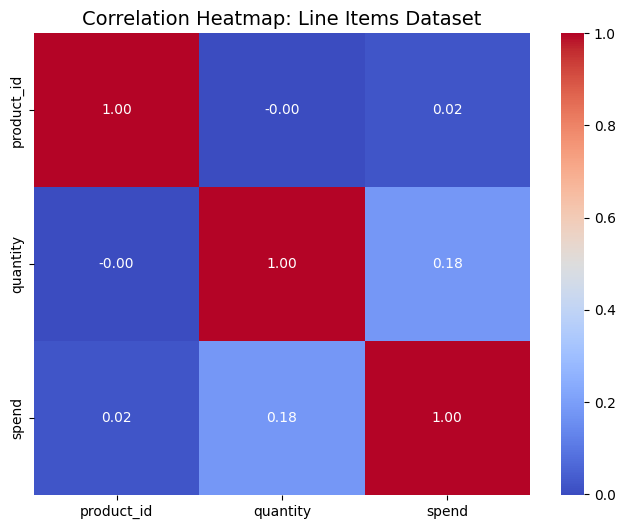

In [ ]:
# Correlation Analysis
def plot_corr_heatmap(df, dataset_name, figsize=(8, 6), id_cols=None):
    if id_cols is None:
        id_cols = []
    # Select numeric columns and drop identifier columns.
    df_numeric = df.select_dtypes(include=[np.number]).drop(columns=id_cols, errors='ignore')

    if not df_numeric.empty:
        plt.figure(figsize=figsize)
        corr = df_numeric.corr()
        sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
        plt.title(f"Correlation Heatmap: {dataset_name}", fontsize=14)
        plt.show()

# For the Customers dataset
plot_corr_heatmap(customers, "Customers Dataset", figsize=(8, 6), id_cols=["customer_number"])

# For the Baskets dataset
plot_corr_heatmap(baskets, "Baskets Dataset", figsize=(8, 6), id_cols=["customer_number"])

# For the Category Spends dataset
plot_corr_heatmap(category_spends, "Category Spends Dataset", figsize=(10, 8), id_cols=["customer_number"])

# For the Line Items dataset
plot_corr_heatmap(lineitems, "Line Items Dataset", figsize=(8, 6), id_cols=["customer_number"])

**5. Feature Engineering & Aggregation**

In [ ]:
# Recency: Days since last purchase from baskets
max_date = baskets['purchase_time'].max()
recency_df = baskets.groupby('customer_number')['purchase_time'].max().reset_index()
recency_df['recency'] = (max_date - recency_df['purchase_time']).dt.days
recency_df.drop('purchase_time', axis=1, inplace=True)

# Tenure: Days since first purchase
min_date = baskets['purchase_time'].min()
tenure_df = baskets.groupby('customer_number')['purchase_time'].min().reset_index()
tenure_df['tenure'] = (tenure_df['purchase_time'] - min_date).dt.days
tenure_df.drop('purchase_time', axis=1, inplace=True)

# Unique Category Count: From lineitems
unique_cat_df = lineitems.groupby('customer_number')['category'].nunique().reset_index()
unique_cat_df.rename(columns={'category': 'unique_category_count'}, inplace=True)

# Average Basket Categories: From baskets
avg_basket_cat_df = baskets.groupby('customer_number')['basket_categories'].mean().reset_index()
avg_basket_cat_df.rename(columns={'basket_categories': 'avg_basket_categories'}, inplace=True)

# Category Diversity: Count non-zero category spend entries from category_spends
spend_cols = [col for col in category_spends.columns if col != 'customer_number']
category_spends['category_diversity'] = category_spends[spend_cols].gt(0).sum(axis=1)
cat_div_df = category_spends[['customer_number', 'category_diversity']]

# Average Spend per Item: total_spend divided by total_quantity
customers['avg_spend_per_item'] = customers.apply(
    lambda row: row['total_spend'] / row['total_quantity'] if row['total_quantity'] > 0 else 0, axis=1
)

# Average Basket Spend & Average Item Count from baskets
avg_basket_spend_df = baskets.groupby('customer_number')['basket_spend'].mean().reset_index()
avg_basket_spend_df.rename(columns={'basket_spend': 'avg_basket_spend'}, inplace=True)

avg_item_count_df = baskets.groupby('customer_number')['basket_quantity'].mean().reset_index()
avg_item_count_df.rename(columns={'basket_quantity': 'avg_item_count'}, inplace=True)

# Average Days Between Purchases
def compute_avg_days_between(purchase_times):
    # purchase_times is a Series - sort it
    purchase_times = purchase_times.sort_values()
    if len(purchase_times) > 1:
        return purchase_times.diff().dt.days.mean()
    else:
        return np.nan

# Group on the purchase_time column instead of the full DataFrame
avg_days_between_df = baskets.groupby('customer_number')['purchase_time'] \
    .apply(compute_avg_days_between) \
    .reset_index(name='avg_days_between')

median_days = avg_days_between_df['avg_days_between'].median()
avg_days_between_df['avg_days_between'] = avg_days_between_df['avg_days_between'].fillna(median_days)


In [ ]:
# Create proportion of total spend for top categories
top_categories = [
    "tobacco", "dairy", "fruit_veg",
    "drinks", "grocery_health_pets",
    "grocery_food", "confectionary",
    "meat", "bakery"
]

# Create a rename map so each category column becomes "spend_<category>"
rename_map = {cat: f"spend_{cat}" for cat in top_categories}

# Make a copy of category_spends and rename columns
category_spends_renamed = category_spends.copy()
category_spends_renamed.rename(columns=rename_map, inplace=True)

cat_spend_cols = list(rename_map.values())  # eg: ['spend_tobacco', 'spend_dairy', ...]
category_spends_renamed['total_cat_spend'] = category_spends_renamed[cat_spend_cols].sum(axis=1)

# Create proportion columns for each top category
for cat in top_categories:
    spend_col = f"spend_{cat}"
    prop_col = f"prop_{cat}"
    category_spends_renamed[prop_col] = np.where(
        category_spends_renamed['total_cat_spend'] > 0,
        category_spends_renamed[spend_col] / category_spends_renamed['total_cat_spend'],
        0
    )

# Build separate DataFrames for absolute spends and proportions
top_cat_df = category_spends_renamed[['customer_number'] + cat_spend_cols].copy()
prop_cols = [f"prop_{cat}" for cat in top_categories]
prop_df = category_spends_renamed[['customer_number'] + prop_cols].copy()

In [ ]:
# Merge All Engineered DataFrames

customer_features = customers.copy()

customer_features = customer_features.merge(recency_df, on='customer_number', how='left')
customer_features = customer_features.merge(tenure_df, on='customer_number', how='left')
customer_features = customer_features.merge(unique_cat_df, on='customer_number', how='left')
customer_features = customer_features.merge(avg_basket_cat_df, on='customer_number', how='left')
customer_features = customer_features.merge(cat_div_df, on='customer_number', how='left')
customer_features = customer_features.merge(avg_basket_spend_df, on='customer_number', how='left')
customer_features = customer_features.merge(avg_item_count_df, on='customer_number', how='left')
customer_features = customer_features.merge(avg_days_between_df, on='customer_number', how='left')

# Merge top category spend columns
customer_features = customer_features.merge(top_cat_df, on='customer_number', how='left')

# Merge proportion columns
customer_features = customer_features.merge(prop_df, on='customer_number', how='left')

In [ ]:
# Print columns in Customer_Features
print("Columns in customer_features:")
print(tabulate([[col] for col in customer_features.columns], headers=["Column Name"], tablefmt="grid"))

print("\nFirst 5 rows of customer_features:")
print(tabulate(customer_features.head(), headers='keys', tablefmt='psql'))

Columns in customer_features:
+---------------------------+
| Column Name               |
+===========================+
| customer_number           |
+---------------------------+
| baskets                   |
+---------------------------+
| total_quantity            |
+---------------------------+
| average_quantity          |
+---------------------------+
| total_spend               |
+---------------------------+
| average_spend             |
+---------------------------+
| avg_spend_per_item        |
+---------------------------+
| recency                   |
+---------------------------+
| tenure                    |
+---------------------------+
| unique_category_count     |
+---------------------------+
| avg_basket_categories     |
+---------------------------+
| category_diversity        |
+---------------------------+
| avg_basket_spend          |
+---------------------------+
| avg_item_count            |
+---------------------------+
| avg_days_between          |
+---------

**6. Conditional Imputation**

In [ ]:
# Fill Missing Values with Median
customer_features.fillna(customer_features.median(), inplace=True)

print("Missing values after imputation:")
print(tabulate(customer_features.isna().sum().reset_index().rename(columns={0:"Missing"}), headers=["Column", "Missing"], tablefmt="psql"))
print("\n")

Missing values after imputation:
+----+---------------------------+-----------+
|    | Column                    |   Missing |
|----+---------------------------+-----------|
|  0 | customer_number           |         0 |
|  1 | baskets                   |         0 |
|  2 | total_quantity            |         0 |
|  3 | average_quantity          |         0 |
|  4 | total_spend               |         0 |
|  5 | average_spend             |         0 |
|  6 | avg_spend_per_item        |         0 |
|  7 | recency                   |         0 |
|  8 | tenure                    |         0 |
|  9 | unique_category_count     |         0 |
| 10 | avg_basket_categories     |         0 |
| 11 | category_diversity        |         0 |
| 12 | avg_basket_spend          |         0 |
| 13 | avg_item_count            |         0 |
| 14 | avg_days_between          |         0 |
| 15 | spend_tobacco             |         0 |
| 16 | spend_dairy               |         0 |
| 17 | spend_fruit_veg     

**7. Outlier Treatment**

In [ ]:
# Cap Outliers Using IQR

continuous_cols = customer_features.select_dtypes(include=[np.number]).columns.tolist()
for col_to_remove in ['customer_number', 'kmeans_cluster', 'dbscan_label']:
    if col_to_remove in continuous_cols:
        continuous_cols.remove(col_to_remove)

for col in continuous_cols:
    Q1 = customer_features[col].quantile(0.25)
    Q3 = customer_features[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    customer_features[col] = np.where(customer_features[col] < lower_bound, lower_bound, customer_features[col])
    customer_features[col] = np.where(customer_features[col] > upper_bound, upper_bound, customer_features[col])

print("Summary statistics after outlier capping:")
print(tabulate(customer_features.describe().T.reset_index(), headers="keys", tablefmt="psql"))
print("\n")

Summary statistics after outlier capping:
+----+---------------------------+---------+--------------+--------------+------------+--------------+--------------+--------------+--------------+
|    | index                     |   count |         mean |          std |        min |          25% |          50% |          75% |          max |
|----+---------------------------+---------+--------------+--------------+------------+--------------+--------------+--------------+--------------|
|  0 | customer_number           |    3000 | 8095.72      | 4686.26      | 14         | 4044.75      | 8218.5       | 12115.5      | 16316        |
|  1 | baskets                   |    3000 |  472.934     |  285.371     |  6         |  257         |  417         |   628.25     |  1185.12     |
|  2 | total_quantity            |    3000 |  564.588     |  338.475     |  6         |  307.75      |  495         |   744.25     |  1399        |
|  3 | average_quantity          |    3000 |    1.19614   |    0.10562

**8. Skew and Log Transform**

In [ ]:
# Check Skew & Log Transform the features

excluded_cols = ["customer_number", "kmeans_cluster", "dbscan_label"]
all_candidate_features = [
    c for c in customer_features.select_dtypes(include=[np.number]).columns
    if c not in excluded_cols
]

def check_and_log_transform(df, cols, skew_threshold=1.0):
    """
    Check skew for each numeric column in 'cols'. If abs(skew) > skew_threshold,
    create a new column 'log_<col>' using log1p transformation.
    """
    # Compute skew for all candidate columns
    skew_series = df[cols].skew()

    results = []
    for c in skew_series.index:
        skew_val = skew_series[c]
        if abs(skew_val) > skew_threshold:
            new_col = f"log_{c}"
            df[new_col] = np.log1p(df[c])  # log(1 + x)
            results.append([c, f"{skew_val:.2f}", "Log-transformed", new_col])
        else:
            results.append([c, f"{skew_val:.2f}", "No transformation", "N/A"])

    print("\n--- Skew & Log Transform Summary ---")
    print(tabulate(results, headers=["Column", "Skew", "Action", "New Column"], tablefmt="psql"))
    return df

# Apply skew check & log transform on all numeric features (excluding IDs/clusters)
customer_features = check_and_log_transform(
    customer_features,
    all_candidate_features,
    skew_threshold=1.0
)


--- Skew & Log Transform Summary ---
+---------------------------+--------+-------------------+-------------------------------+
| Column                    |   Skew | Action            | New Column                    |
|---------------------------+--------+-------------------+-------------------------------|
| baskets                   |   0.86 | No transformation | N/A                           |
| total_quantity            |   0.85 | No transformation | N/A                           |
| average_quantity          |   0.79 | No transformation | N/A                           |
| total_spend               |   0.89 | No transformation | N/A                           |
| average_spend             |   0.89 | No transformation | N/A                           |
| avg_spend_per_item        |   0.84 | No transformation | N/A                           |
| recency                   |   1.31 | Log-transformed   | log_recency                   |
| tenure                    |   1.24 | Log-transform

**9. Pearson Correlation**


Candidate features for Pearson correlation:
+-------------------------------+
| Feature                       |
|-------------------------------|
| baskets                       |
| log_recency                   |
| log_tenure                    |
| unique_category_count         |
| avg_basket_categories         |
| category_diversity            |
| avg_basket_spend              |
| log_avg_item_count            |
| log_avg_days_between          |
| total_spend                   |
| average_spend                 |
| avg_spend_per_item            |
| log_spend_tobacco             |
| spend_dairy                   |
| log_spend_fruit_veg           |
| log_spend_drinks              |
| log_spend_grocery_health_pets |
| log_spend_grocery_food        |
| log_spend_confectionary       |
| log_spend_meat                |
| spend_bakery                  |
| log_prop_tobacco              |
| prop_dairy                    |
| prop_fruit_veg                |
| log_prop_drinks               |
| p

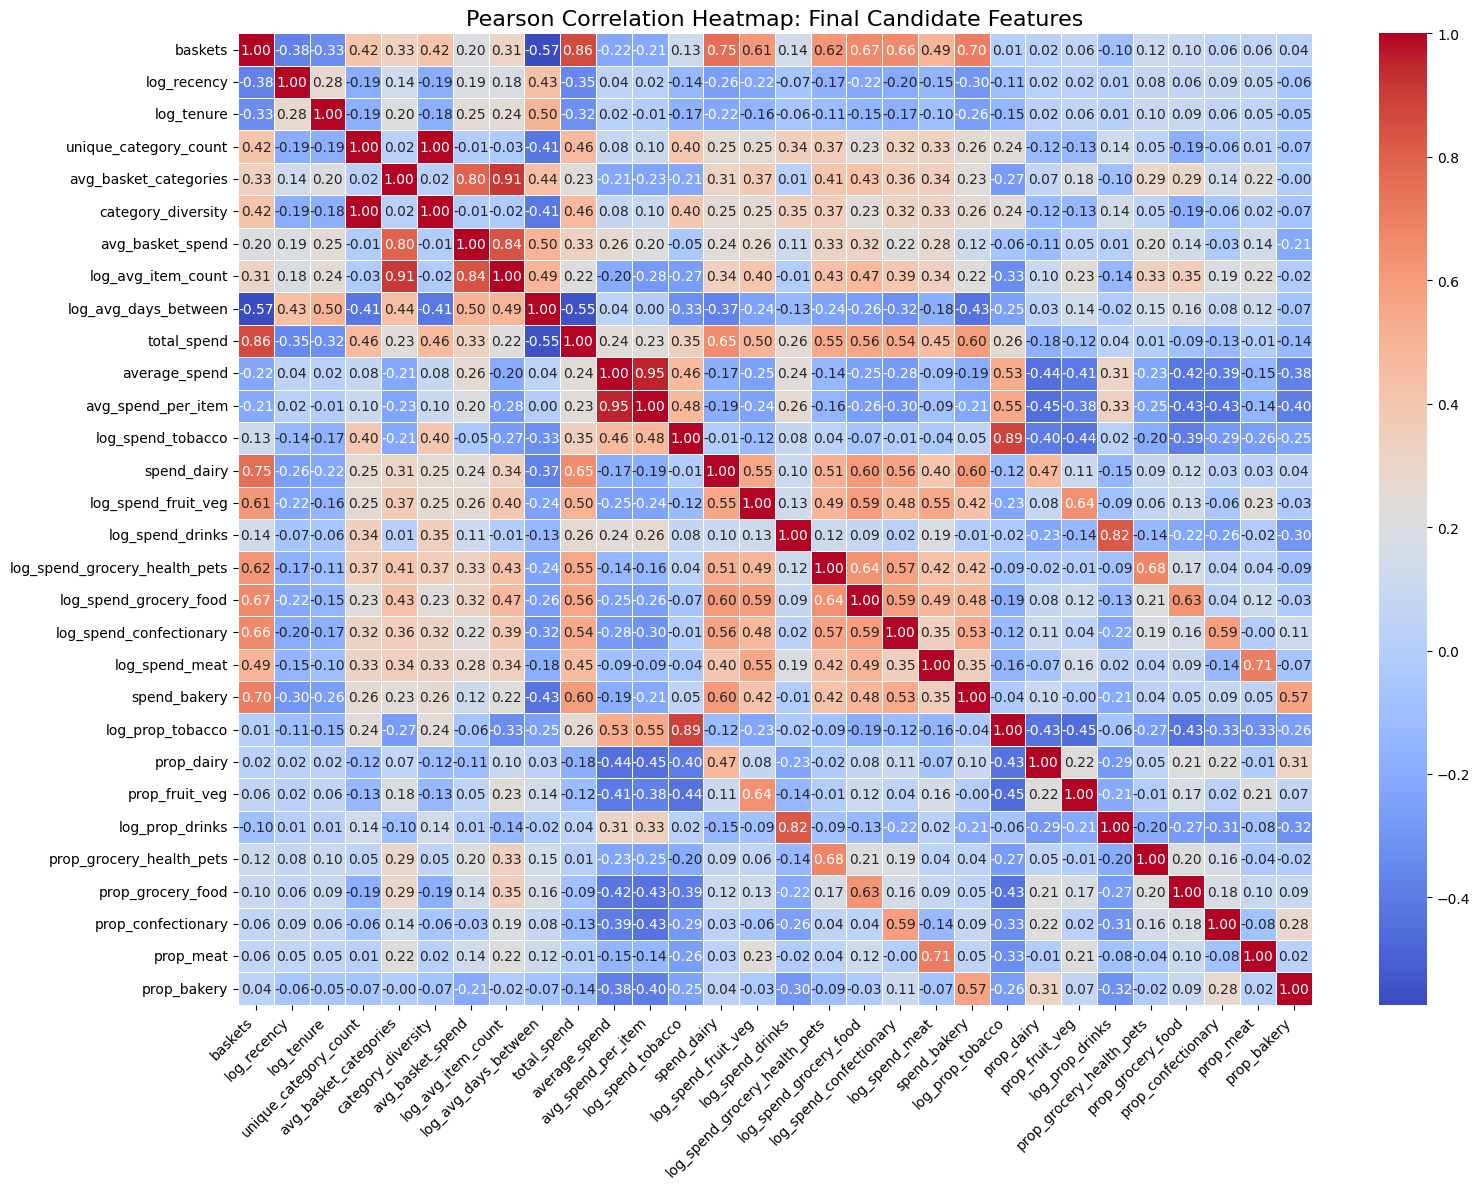

In [ ]:
# Build Candidate Feature List for Pearson Correlation

# Define feature groups (excluding total_quantity & average_quantity)
base_features = [
    "baskets",
    "recency",
    "tenure",
    "unique_category_count",
    "avg_basket_categories",
    "category_diversity",
    "avg_basket_spend",
    "avg_item_count",
    "avg_days_between",
    "total_spend",
    "average_spend",
    "avg_spend_per_item"
]

top_cat_features = [
    "spend_tobacco",
    "spend_dairy",
    "spend_fruit_veg",
    "spend_drinks",
    "spend_grocery_health_pets",
    "spend_grocery_food",
    "spend_confectionary",
    "spend_meat",
    "spend_bakery"
]

proportion_features = [
    "prop_tobacco",
    "prop_dairy",
    "prop_fruit_veg",
    "prop_drinks",
    "prop_grocery_health_pets",
    "prop_grocery_food",
    "prop_confectionary",
    "prop_meat",
    "prop_bakery"
]

# Combine them all
all_feature_candidates = base_features + top_cat_features + proportion_features

# Build candidate_features list by checking if 'log_<feature>' exists
candidate_features = []
for feat in all_feature_candidates:
    log_feat = f"log_{feat}"
    if log_feat in customer_features.columns:
        candidate_features.append(log_feat)
    else:
        candidate_features.append(feat)

print("\nCandidate features for Pearson correlation:")
print(tabulate([[f] for f in candidate_features], headers=["Feature"], tablefmt="psql"))

# Correlation matrix
corr_matrix = customer_features[candidate_features].corr(method="pearson")

plt.figure(figsize=(16, 12))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    annot_kws={"size": 10},
    linewidths=0.5,
    linecolor="white"
)
plt.title("Pearson Correlation Heatmap: Final Candidate Features", fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

**10. Define Final Features, Scale, & Perform PCA**

In [ ]:
def pick_log_or_original(df, feature_name):
    log_name = f"log_{feature_name}"
    return log_name if log_name in df.columns else feature_name

"""
Define feature groups while excluding certain features based on Pearson correlation:
Excluded features:- total_quantity, average_quantity, category_diversity, avg_basket_categories, avg_spend_per_item
"""

base_features = [
    "baskets",                 # frequency (F)
    "recency",                 # days since last purchase (R)
    "tenure",                  # days since first purchase
    "unique_category_count",   # variety in product categories
    "avg_basket_spend",        # keep both avg_basket_spend
    "avg_item_count",          # and log_avg_item_count if it exists
    "avg_days_between",        # days between purchases
    "total_spend",             # overall spend (M)
    "average_spend"            # average spend per visit
]

# For category spends, keeping all the main categories except tobacco as 'spend_tobacco' is correlated with 'prop_tobacco'(prefering proportion for tobacco).
top_cat_features = [
    "spend_dairy",
    "spend_fruit_veg",
    "spend_drinks",
    "spend_grocery_health_pets",
    "spend_grocery_food",
    "spend_confectionary",
    "spend_meat",
    "spend_bakery"
]

# For proportions, considering only the first three.
proportion_features = [
    "prop_tobacco",
    "prop_dairy",
    "prop_fruit_veg"
]

# Combine them all into a single list for final candidate features
all_feature_candidates = base_features + top_cat_features + proportion_features

# Pick log_ versions if available
final_features = []
for feat in all_feature_candidates:
    final_features.append(pick_log_or_original(customer_features, feat))

# Print the final feature list
print("\n--- Final Features for Clustering & PCA ---\n")
print(tabulate([[f] for f in final_features], headers=["Feature"], tablefmt="psql"))

# Scale the final features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(customer_features[final_features])
print(f"\nScaled feature matrix shape: {X_scaled.shape}")


--- Final Features for Clustering & PCA ---

+-------------------------------+
| Feature                       |
|-------------------------------|
| baskets                       |
| log_recency                   |
| log_tenure                    |
| unique_category_count         |
| avg_basket_spend              |
| log_avg_item_count            |
| log_avg_days_between          |
| total_spend                   |
| average_spend                 |
| spend_dairy                   |
| log_spend_fruit_veg           |
| log_spend_drinks              |
| log_spend_grocery_health_pets |
| log_spend_grocery_food        |
| log_spend_confectionary       |
| log_spend_meat                |
| spend_bakery                  |
| log_prop_tobacco              |
| prop_dairy                    |
| prop_fruit_veg                |
+-------------------------------+

Scaled feature matrix shape: (3000, 20)


In [ ]:
# Auto-Select PCA Dimension Based on Cumulative Variance (eg-80%)

pca_full = PCA(random_state=42)
pca_full.fit(X_scaled)

# Compute cumulative explained variance
variance_ratios = pca_full.explained_variance_ratio_
cumulative_var = np.cumsum(variance_ratios)

# Pick the smallest number of components that covers >=80% of variance
threshold = 0.80
pca_dim = np.argmax(cumulative_var >= threshold) + 1
print(f"\nSelecting {pca_dim} components to cover at least {threshold*100}% variance.")

# Define a PCA object with that dimension
pca_for_clustering = PCA(n_components=pca_dim, random_state=42)
X_pca = pca_for_clustering.fit_transform(X_scaled)

print(f"Explained Variance Ratio (first {pca_dim} PCs):",
      pca_for_clustering.explained_variance_ratio_)
print(f"Shape of PCA-transformed data: {X_pca.shape}")


Selecting 8 components to cover at least 80.0% variance.
Explained Variance Ratio (first 8 PCs): [0.32376861 0.16180134 0.11923227 0.06423619 0.05052071 0.04341962
 0.03684485 0.03567176]
Shape of PCA-transformed data: (3000, 8)


**11. K-Means**


--- K-Means K-Range Evaluation (on PCA Data) ---
    k           SSE  Silhouette  Calinski-Harabasz  Davies-Bouldin
0   2  37942.767957    0.203320         962.936794        1.696955
1   3  33175.642338    0.168272         765.804903        1.817321
2   4  29901.707744    0.156573         675.584724        1.737344
3   5  27326.357029    0.159361         624.825344        1.632706
4   6  25571.318275    0.152675         575.083320        1.654787
5   7  24524.180102    0.141769         520.830438        1.670856
6   8  23495.706524    0.132992         484.519972        1.747184
7   9  22569.929822    0.132512         456.532974        1.722889
8  10  21802.818536    0.131710         431.634561        1.679307


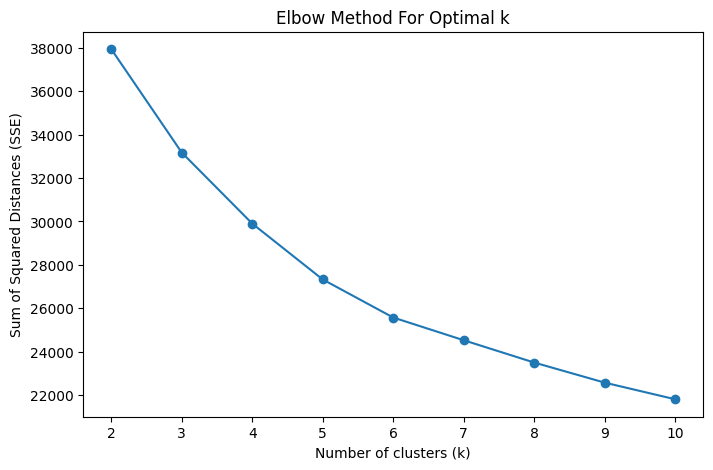

In [ ]:
# Evaluate K range with SSE and Advanced Metrics on X_pca
k_range = range(2, 11)
results = []

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init='auto')
    km.fit(X_pca)
    labels = km.labels_
    sse_val = km.inertia_
    sil = silhouette_score(X_pca, labels)
    ch = calinski_harabasz_score(X_pca, labels)
    db = davies_bouldin_score(X_pca, labels)
    results.append((k, sse_val, sil, ch, db))

metrics_df = pd.DataFrame(results, columns=['k', 'SSE', 'Silhouette', 'Calinski-Harabasz', 'Davies-Bouldin'])
print("\n--- K-Means K-Range Evaluation (on PCA Data) ---")
print(metrics_df)

plt.figure(figsize=(8, 5))
plt.plot(metrics_df['k'], metrics_df['SSE'], marker='o')
plt.title("Elbow Method For Optimal k")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Sum of Squared Distances (SSE)")
plt.xticks(metrics_df['k'])
plt.show()


In [ ]:
# Choose k and Fit Final K-Means
best_k = 5  # choose the apt value for k
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init='auto')
kmeans.fit(X_pca)
customer_features['kmeans_cluster'] = kmeans.labels_

sil_km = silhouette_score(X_pca, kmeans.labels_)
print(f"\nK-Means (k={best_k}) Silhouette: {sil_km:.4f}")


K-Means (k=5) Silhouette: 0.1594


**12. DBSCAN**

In [ ]:
# DBSCAN with Grid Search for eps
eps_values = np.arange(0.1, 2.1, 0.1)
best_eps = None
best_silhouette = -1.0

for eps_candidate in eps_values:
    dbscan_temp = DBSCAN(eps=eps_candidate, min_samples=5)
    labels_temp = dbscan_temp.fit_predict(X_pca)

    # Exclude noise (-1) for silhouette if there's more than 1 valid cluster
    valid_mask = (labels_temp != -1)
    valid_labels = labels_temp[valid_mask]
    if len(np.unique(valid_labels)) > 1:
        sil_temp = silhouette_score(X_pca[valid_mask], valid_labels)
        if sil_temp > best_silhouette:
            best_silhouette = sil_temp
            best_eps = eps_candidate

if best_eps is None:
    print("No suitable eps found that forms more than 1 cluster. DBSCAN might label everything as noise.")
else:
    print(f"\nBest eps found: {best_eps:.2f} with silhouette (no noise) = {best_silhouette:.4f}")

    # Final DBSCAN with the best eps
    dbscan = DBSCAN(eps=best_eps, min_samples=5)
    dbscan_labels = dbscan.fit_predict(X_pca)
    customer_features['dbscan_label'] = dbscan_labels

    valid_mask = (dbscan_labels != -1)
    valid_labels = dbscan_labels[valid_mask]
    if len(np.unique(valid_labels)) > 1:
        sil_db = silhouette_score(X_pca[valid_mask], valid_labels)
        ch_db = calinski_harabasz_score(X_pca[valid_mask], valid_labels)
        db_db = davies_bouldin_score(X_pca[valid_mask], valid_labels)
        print(f"[DBSCAN:- best eps={best_eps:.2f}] Silhouette (no noise): {sil_db:.4f}, "
              f"CH: {ch_db:.2f}, DB: {db_db:.2f}")
    else:
        print(f"[DBSCAN:- best eps={best_eps:.2f}] Only one cluster or all noise; metrics not computed.")


Best eps found: 1.00 with silhouette (no noise) = 0.4261
[DBSCAN:- best eps=1.00] Silhouette (no noise): 0.4261, CH: 11.62, DB: 0.79


**13. PCA Visualization**

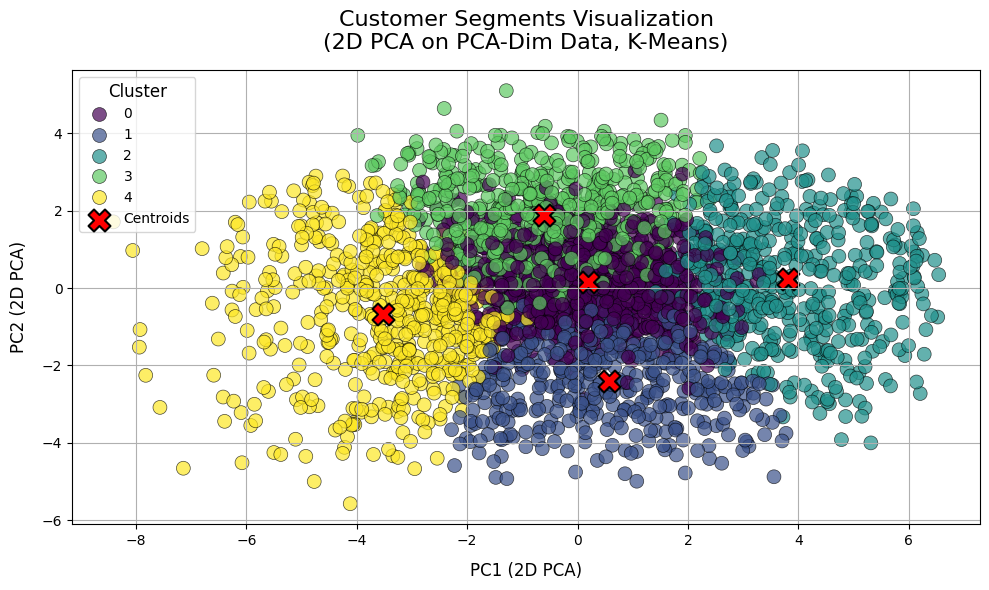

In [ ]:
# Enhanced Visualization of Clusters

# Project data and centroids into 2D PCA space
pca_2d = PCA(n_components=2, random_state=42)
X_pca_2d = pca_2d.fit_transform(X_pca)  # X_pca: input data from previous PCA
centers_2d = pca_2d.transform(kmeans.cluster_centers_)

# Create a scatterplot for the clustered data points
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=X_pca_2d[:, 0], y=X_pca_2d[:, 1],
    hue=customer_features['kmeans_cluster'],
    palette='viridis', alpha=0.7, s=100,
    edgecolor='black', linewidth=0.5
)

# Overlay the centroids
plt.scatter(
    centers_2d[:, 0], centers_2d[:, 1],
    c='red', s=250, alpha=1, marker='X', label='Centroids',
    edgecolor='black', linewidth=1.5
)

plt.title("Customer Segments Visualization\n(2D PCA on PCA-Dim Data, K-Means)", fontsize=16, pad=15)
plt.xlabel("PC1 (2D PCA)", fontsize=12, labelpad=10)
plt.ylabel("PC2 (2D PCA)", fontsize=12, labelpad=10)
plt.legend(title="Cluster", fontsize=10, title_fontsize=12, loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

**14. Cluster Analysis & Summaries**

In [ ]:
# Cluster Analysis & Summaries
def flatten_multiindex(df):
    # Flatten multi-level column index (eg-(baskets, 'mean') = baskets_mean)
    df = df.copy()
    df.columns = ['_'.join(map(str, col)).strip('_') if isinstance(col, tuple) else col
                  for col in df.columns]
    return df

# Return a DataFrame with mean, std, and median for each feature per cluster
def compute_cluster_summary(df, cluster_col, features):
    """
    df          : DataFrame containing the data
    cluster_col : Name of the column with cluster labels
    features    : List of numeric features to summarize
    """
    grp = df.groupby(cluster_col)[features]
    summary_df = grp.agg(['mean', 'std', 'median']).round(2)
    return summary_df

# Detailed Summaries for K-Means & DBSCAN
print("\n=== K-Means Cluster Summary (mean, std, median) ===")
kmeans_summary = compute_cluster_summary(
    customer_features,
    cluster_col='kmeans_cluster',
    features=final_features
)
print("K-Means Summary (MultiIndex):")
print(tabulate(kmeans_summary, headers="keys", tablefmt="psql"))

# If DBSCAN was computed and found valid clusters, do the same!
dbscan_summary = None
if 'dbscan_label' in customer_features.columns:
    dbscan_valid = customer_features[customer_features['dbscan_label'] != -1]
    if not dbscan_valid.empty:
        print("\n=== DBSCAN Cluster Summary (mean, std, median; excluding noise) ===")
        dbscan_summary = compute_cluster_summary(
            dbscan_valid,
            cluster_col='dbscan_label',
            features=final_features
        )
        print("DBSCAN Summary (MultiIndex):")
        print(tabulate(dbscan_summary, headers="keys", tablefmt="psql"))
    else:
        print("\nDBSCAN: All points labeled noise or single cluster => no valid cluster summary.")
else:
    print("\nDBSCAN labels not found. Skipping DBSCAN summary.")

# Flatten Summaries to fix the tuple columns
kmeans_summary_flat = flatten_multiindex(kmeans_summary)
dbscan_summary_flat = flatten_multiindex(dbscan_summary) if dbscan_summary is not None else None

print("\n--- Flattened Summaries ---")
print("K-Means Summary (Flattened):")
print(tabulate(kmeans_summary_flat, headers="keys", tablefmt="psql"))
if dbscan_summary_flat is not None:
    print("DBSCAN Summary (Flattened):")
    print(tabulate(dbscan_summary_flat, headers="keys", tablefmt="psql"))

# Decide which method is best
print("\n=== Silhouette Scores ===")
silhouette_data = []
silhouette_data.append(["K-Means (k=5)", f"{sil_km:.4f}"])
if best_eps is not None:
    silhouette_data.append([f"DBSCAN (eps={best_eps:.2f})", f"{best_silhouette:.4f}"])
else:
    silhouette_data.append(["DBSCAN", "No suitable eps"])

print(tabulate(silhouette_data, headers=["Method", "Silhouette Score"], tablefmt="psql"))

if best_eps is not None and best_silhouette > sil_km:
    better_method = "DBSCAN appears better based on silhouette score."
else:
    better_method = "K-Means is chosen (or they are tied)."

print("\n" + better_method)


=== K-Means Cluster Summary (mean, std, median) ===
K-Means Summary (MultiIndex):
+------------------+-----------------------+----------------------+-------------------------+---------------------------+--------------------------+-----------------------------+--------------------------+-------------------------+----------------------------+-------------------------------------+------------------------------------+---------------------------------------+--------------------------------+-------------------------------+----------------------------------+----------------------------------+---------------------------------+------------------------------------+------------------------------------+-----------------------------------+--------------------------------------+---------------------------+--------------------------+-----------------------------+-----------------------------+----------------------------+-------------------------------+---------------------------+--------------------

In [ ]:
unique_labels = np.unique(customer_features['dbscan_label'])
print("DBSCAN cluster labels found:", unique_labels)

DBSCAN cluster labels found: [-1  0  1]


In [ ]:
def plot_radar_charts_for_clusters(cluster_summary_flat, final_features, cluster_label_name="K-Means (k=5)"):
    # Identifying the '_mean' columns
    mean_cols = []
    for feat in final_features:
        col_name = f"{feat}_mean"
        if col_name in cluster_summary_flat.columns:
            mean_cols.append(col_name)
        else:
            print(f"Warning: {col_name} not found in cluster_summary_flat.")

    if not mean_cols:
        print("No valid _mean columns found for radar chart.")
        return

    # Extract the cluster means into a NumPy array for plotting
    data = cluster_summary_flat[mean_cols].values

    # Normalize each feature’s mean to [0,1] range
    min_vals = data.min(axis=0)
    max_vals = data.max(axis=0)
    norm_data = (data - min_vals) / (max_vals - min_vals + 1e-9)

    # Prepare angles for the radar chart.
    n_features = len(mean_cols)
    angles = np.linspace(0, 2 * np.pi, n_features, endpoint=False).tolist()
    # Closing the loop
    angles += angles[:1]

    # Create the figure and polar axis.
    fig, ax = plt.subplots(figsize=(8, 6), subplot_kw=dict(polar=True))
    cluster_ids = cluster_summary_flat.index.tolist()

    for i, cid in enumerate(cluster_ids):
        # Append the first value to the end so the polygon closes
        values = norm_data[i].tolist()
        values += values[:1]

        ax.plot(angles, values, label=f"Cluster {cid}", linewidth=2)
        ax.fill(angles, values, alpha=0.1)

    # Format the radial axes with feature labels
    ax.set_theta_offset(np.pi / 2)  # the first feature at the top
    ax.set_theta_direction(-1) # clockwise

    # Remove the _mean suffix for labeling
    feature_labels = [col.replace("_mean", "") for col in mean_cols]
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(feature_labels, fontsize=10)

    ax.set_ylim(0, 1)

    plt.title(f"Radar Chart for {cluster_label_name} Clusters", fontsize=14, pad=20)
    ax.legend(loc='upper right', bbox_to_anchor=(1.25, 1.1))

    plt.tight_layout()
    plt.show()

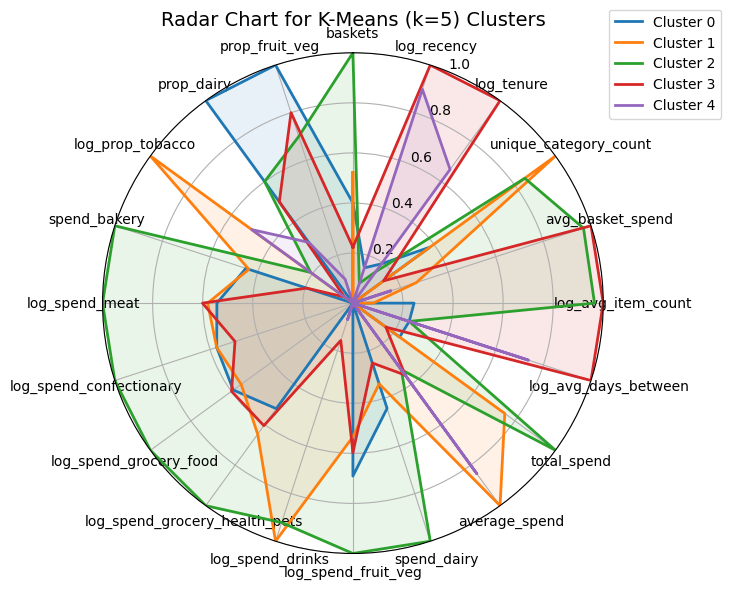

In [ ]:
plot_radar_charts_for_clusters(
    cluster_summary_flat=kmeans_summary_flat,
    final_features=final_features,
    cluster_label_name="K-Means (k=5)"
)

**15. Save Customer Segmentation Results**

In [ ]:
"""
- DBSCAN is ignored despite a higher silhouette score as it produces fewer clusters.
- Proceeding with K=5 for the final segmentation.
"""
kmeans_results = customer_features[['customer_number', 'kmeans_cluster']].copy()
kmeans_results.to_csv("kmeans_segmentation_results.csv", index=False)
print("K-Means segmentation results saved to 'kmeans_segmentation_results.csv'.")

K-Means segmentation results saved to 'kmeans_segmentation_results.csv'.


**16. Pen Profiles**

In [ ]:
# Generate Pen Profiles

# This method returns a dictionary with cluster IDs as keys and narrative pen portraits as values.
def generate_pen_portraits(
    df,
    cluster_col,
    features,
    cluster_summary,
    cluster_label_name="Cluster",
    high_low_ratio=1.2
):
    if cluster_summary is None:
        print(f"No summary available for {cluster_label_name}.")
        return {}

    # Get all columns ending in _mean
    mean_cols = [c for c in cluster_summary.columns if c.endswith("_mean")]

    # Compute the overall mean from df
    base_feats = {mc.replace("_mean", "") for mc in mean_cols}
    overall_means = {feat: df[feat].mean() for feat in base_feats if feat in df.columns}

    pen_portraits = {}

    # Loop over each cluster summary
    for idx, row in cluster_summary.iterrows():
        cluster_id = idx
        lines = [f"Pen Portrait for {cluster_label_name} {cluster_id}:"]
        feature_flags = {}

        # Loop through each feature using its _mean value
        for mc in mean_cols:
            base_feat = mc.replace("_mean", "")
            if base_feat not in overall_means:
                continue
            cluster_val = row[mc]
            # Prevent division by zero with a very small number
            overall_mean = overall_means[base_feat] if overall_means[base_feat] != 0 else 1e-9
            ratio = cluster_val / overall_mean

            if ratio >= high_low_ratio:
                feature_flags[base_feat] = "High"
                descriptor = f"High {base_feat} (ratio={ratio:.2f})"
            elif ratio <= (1.0 / high_low_ratio):
                feature_flags[base_feat] = "Low"
                descriptor = f"Low {base_feat} (ratio={ratio:.2f})"
            else:
                feature_flags[base_feat] = "Avg"
                descriptor = f"Avg {base_feat} (ratio={ratio:.2f})"
            lines.append(descriptor)

        # Setting up marketing-oriented insights for each key feature.
        marketing_insights = []

        # Frequency & recency
        if feature_flags.get('baskets') == "High":
            marketing_insights.append("They visit very frequently.")
        elif feature_flags.get('baskets') == "Low":
            marketing_insights.append("They visit infrequently.")

        if feature_flags.get('log_recency') == "Low":
            marketing_insights.append("They are very active, having purchased very recently.")
        elif feature_flags.get('log_recency') == "High":
            marketing_insights.append("They haven't shopped recently and may require re-engagement.")

        # Tenure
        if feature_flags.get('log_tenure') == "High":
            marketing_insights.append("They have been loyal customers for a long time.")
        elif feature_flags.get('log_tenure') == "Low":
            marketing_insights.append("They are relatively new customers.")

        # Unique category count
        if feature_flags.get('unique_category_count') == "High":
            marketing_insights.append("They have diverse shopping habits, exploring many product categories.")
        elif feature_flags.get('unique_category_count') == "Low":
            marketing_insights.append("They focus on a limited range of product categories.")

        # Average basket spend
        if feature_flags.get('avg_basket_spend') == "High":
            marketing_insights.append("They tend to purchase large baskets on each visit.")
        elif feature_flags.get('avg_basket_spend') == "Low":
            marketing_insights.append("They usually buy only a few items per visit.")

        # Average item count per basket
        if feature_flags.get('log_avg_item_count') == "High":
            marketing_insights.append("They consistently buy many items per basket.")
        elif feature_flags.get('log_avg_item_count') == "Low":
            marketing_insights.append("They buy few items per basket, indicating quick trips.")

        # Average days between purchases
        if feature_flags.get('log_avg_days_between') == "High":
            marketing_insights.append("They have longer intervals between purchases.")
        elif feature_flags.get('log_avg_days_between') == "Low":
            marketing_insights.append("They shop very frequently with short intervals between visits.")

        # Total spend and average spend
        if feature_flags.get('total_spend') == "High":
            marketing_insights.append("They contribute high total revenue.")
        elif feature_flags.get('total_spend') == "Low":
            marketing_insights.append("They contribute lower total revenue.")

        if feature_flags.get('average_spend') == "High":
            marketing_insights.append("They spend a lot per visit, indicating premium preferences.")
        elif feature_flags.get('average_spend') == "Low":
            marketing_insights.append("They tend to spend less per visit, suggesting budget sensitivity.")

        # Spend on dairy
        if feature_flags.get('spend_dairy') == "High":
            marketing_insights.append("They invest considerably in dairy products.")
        elif feature_flags.get('spend_dairy') == "Low":
            marketing_insights.append("Their dairy spending is low.")

        # Fruit & Veg spending
        if feature_flags.get('log_spend_fruit_veg') == "High":
            marketing_insights.append("They are health-conscious with high fruit & veg purchases.")
        elif feature_flags.get('log_spend_fruit_veg') == "Low":
            marketing_insights.append("Their fruit & veg spending is lower than average.")

        # Drinks spending
        if feature_flags.get('log_spend_drinks') == "High":
            marketing_insights.append("They purchase a lot of drinks, perhaps for social events.")
        elif feature_flags.get('log_spend_drinks') == "Low":
            marketing_insights.append("Their spending on drinks is modest.")

        # Grocery Health & Pets spending
        if feature_flags.get('log_spend_grocery_health_pets') == "High":
            marketing_insights.append("They spend significantly on grocery, health, and pet products.")
        elif feature_flags.get('log_spend_grocery_health_pets') == "Low":
            marketing_insights.append("They allocate a lower share to grocery/health/pet items.")

        # Grocery Food spending
        if feature_flags.get('log_spend_grocery_food') == "High":
            marketing_insights.append("They invest heavily in grocery food items.")
        elif feature_flags.get('log_spend_grocery_food') == "Low":
            marketing_insights.append("Their grocery food spend is below average.")

        # Confectionary spending
        if feature_flags.get('log_spend_confectionary') == "High":
            marketing_insights.append("They are big on confectionary, indicating a sweet tooth.")
        elif feature_flags.get('log_spend_confectionary') == "Low":
            marketing_insights.append("They spend little on confectionary products.")

        # Meat spending
        if feature_flags.get('log_spend_meat') == "High":
            marketing_insights.append("They have high meat spending, suggesting a preference for protein-rich diets.")
        elif feature_flags.get('log_spend_meat') == "Low":
            marketing_insights.append("They spend less on meat products.")

        # Bakery spending
        if feature_flags.get('spend_bakery') == "High":
            marketing_insights.append("They are enthusiastic bakery shoppers.")
        elif feature_flags.get('spend_bakery') == "Low":
            marketing_insights.append("Bakery purchases are lower than average for this group.")

        # Proportion features
        if feature_flags.get('log_prop_tobacco') == "High":
            marketing_insights.append("Tobacco represents a high share of their spending—targeted promotions for sin-tax items may work.")
        elif feature_flags.get('log_prop_tobacco') == "Low":
            marketing_insights.append("Tobacco spending is minimal.")

        if feature_flags.get('prop_dairy') == "High":
            marketing_insights.append("They dedicate a high proportion of spend to dairy products.")
        elif feature_flags.get('prop_dairy') == "Low":
            marketing_insights.append("Dairy does not constitute a large portion of their spend.")

        if feature_flags.get('prop_fruit_veg') == "High":
            marketing_insights.append("They prioritize fruit and veg, suggesting a health-oriented profile.")
        elif feature_flags.get('prop_fruit_veg') == "Low":
            marketing_insights.append("Their fruit and veg spending proportion is below average.")

        # Combine these insights into a marketing narrative paragraph.
        if marketing_insights:
            marketing_paragraph = "Overall, this cluster can be described as: " + " ".join(marketing_insights)
        else:
            marketing_paragraph = "No major marketing flags identified for this cluster."

        lines.append("\n**Marketing Angle**: " + marketing_paragraph)

        # Combine all lines into one text block for the cluster
        pen_portraits[cluster_id] = "\n".join(lines)

    # Print the pen portraits
    border = "-" * 60
    print(f"\n=== Pen Portraits for {cluster_label_name} ===")
    for cid, portrait in pen_portraits.items():
        print(f"Cluster {cid} Pen Portrait:")
        print(border)
        print(portrait)
        print(border + "\n")

    return pen_portraits

best_pen_portraits = generate_pen_portraits(
    df=customer_features,
    cluster_col="kmeans_cluster",
    features=final_features,
    cluster_summary=kmeans_summary_flat,
    cluster_label_name="K-Means (k=5)",
    high_low_ratio=1.2  # threshold
)


=== Pen Portraits for K-Means (k=5) ===
Cluster 0 Pen Portrait:
------------------------------------------------------------
Pen Portrait for K-Means (k=5) 0:
Avg baskets (ratio=0.99)
Low log_recency (ratio=0.72)
Low log_tenure (ratio=0.75)
Avg unique_category_count (ratio=0.99)
Low avg_basket_spend (ratio=0.63)
Avg log_avg_item_count (ratio=0.92)
Low log_avg_days_between (ratio=0.83)
Low total_spend (ratio=0.80)
Low average_spend (ratio=0.80)
Avg spend_dairy (ratio=1.07)
Avg log_spend_fruit_veg (ratio=1.07)
Avg log_spend_drinks (ratio=0.85)
Avg log_spend_grocery_health_pets (ratio=0.99)
Avg log_spend_grocery_food (ratio=1.03)
Avg log_spend_confectionary (ratio=1.03)
Avg log_spend_meat (ratio=1.00)
Avg spend_bakery (ratio=1.07)
Low log_prop_tobacco (ratio=0.22)
High prop_dairy (ratio=1.32)
High prop_fruit_veg (ratio=1.32)

**Marketing Angle**: Overall, this cluster can be described as: They are very active, having purchased very recently. They are relatively new customers. They usuall

**17. Identify Top Segments**

In [ ]:
# This method returns a DataFrame with an attractiveness_score column
def identify_top_segments(
    cluster_summary_flat,
    cluster_label_name="K-Means (k=5)",
    top_n=2
):
    # Define the features
    needed_cols = [
        "baskets_mean",
        "log_recency_mean",
        "log_tenure_mean",
        "unique_category_count_mean",
        "avg_basket_spend_mean",
        "log_avg_item_count_mean",
        "log_avg_days_between_mean",
        "total_spend_mean",
        "average_spend_mean",
        "spend_dairy_mean",
        "log_spend_fruit_veg_mean",
        "log_spend_drinks_mean",
        "log_spend_grocery_health_pets_mean",
        "log_spend_grocery_food_mean",
        "log_spend_confectionary_mean",
        "log_spend_meat_mean",
        "spend_bakery_mean",
        "log_prop_tobacco_mean",
        "prop_dairy_mean",
        "prop_fruit_veg_mean"
    ]

    # Create a copy and make sure to have a 'cluster_id' column from the index of cluster_summary_flat
    df_score = cluster_summary_flat.copy()

    # Convert the current index to a real column named "cluster_id"
    df_score["cluster_id"] = df_score.index
    # Optionally drop the old index
    df_score.reset_index(drop=True, inplace=True)

    # If columns are missing, fill them with 0 or warn
    for col in needed_cols:
        if col not in df_score.columns:
            print(f"Warning: {col} not found in cluster summary. Setting it to 0.")
            df_score[col] = 0.0

    # Define a weighting scheme:- Positive weight:- bigger is more attractive, Negative weight:- smaller is more attractive

    feature_weights = {
       "baskets_mean": 0.10,                  # + (more frequent visits is better)
       "log_recency_mean": -0.10,             # – (lower recency is better)
       "log_tenure_mean": 0.05,               # + (longer tenure is better)
       "unique_category_count_mean": 0.05,    # + (more category diversity is better)
       "avg_basket_spend_mean": 0.10,         # + (higher avg basket spend is better)
       "log_avg_item_count_mean": 0.05,       # + (more items per basket is better)
       "log_avg_days_between_mean": -0.05,    # – (fewer days between visits is better)
       "total_spend_mean": 0.15,              # + (overall spend is critical)
       "average_spend_mean": 0.10,            # + (higher spend per visit is good)
       "spend_dairy_mean": 0.03,              # + (spending in dairy is desirable)
       "log_spend_fruit_veg_mean": 0.04,      # + (health-conscious category)
       "log_spend_drinks_mean": 0.03,         # + (drinks can be profitable/social)
       "log_spend_grocery_health_pets_mean": 0.05, # + (broad grocery + health/pets)
       "log_spend_grocery_food_mean": 0.05,        # + (core grocery items)
       "log_spend_confectionary_mean": 0.03,       # + (snacks/sweets)
       "log_spend_meat_mean": 0.03,           # + (protein-rich category)
       "spend_bakery_mean": 0.02,             # + (bakery enthusiasts)
       "log_prop_tobacco_mean": -0.02,        # – (lower tobacco proportion is preferred)
       "prop_dairy_mean": 0.02,               # + (higher dairy proportion is good)
       "prop_fruit_veg_mean": 0.02            # + (health-oriented proportion)
    }

    # Normalize each needed feature (min-max) so they are in [0,1].
    def min_max_norm(series):
        return (series - series.min()) / (series.max() - series.min() + 1e-9)

    for col in needed_cols:
        norm_col = f"norm_{col}"
        df_score[norm_col] = min_max_norm(df_score[col])

    # Compute attractiveness_score
    def weighted_score(row):
        score = 0.0
        for col in needed_cols:
            w = feature_weights.get(col, 0.0)
            val = row[f"norm_{col}"]
            if w < 0:
                # invert if negative weight
                score += abs(w) * (1 - val)
            else:
                score += w * val
        return score

    df_score["attractiveness_score"] = df_score.apply(weighted_score, axis=1)

    # Sort by attractiveness_score
    df_score.sort_values(by="attractiveness_score", ascending=False, inplace=True)

    # Print a table with cluster_id and final score
    print(f"\n=== {cluster_label_name}: Extended Attractiveness Ranking ===")
    show_cols = ["cluster_id", "attractiveness_score"] + needed_cols
    print(df_score[show_cols].to_string(index=False))

    # The Top Segments
    print(f"\nTop {top_n} Segments to Target (Highest Attractiveness Score):")
    top_segments = df_score.head(top_n)
    for _, row in top_segments.iterrows():
        cid = row["cluster_id"]
        score = row["attractiveness_score"]
        print(f"  - Cluster {cid} with score={score:.3f}")

    return df_score

In [ ]:
best_cluster_label = "K-Means (k=5)"
cluster_summary_to_use = kmeans_summary_flat

ranked_clusters = identify_top_segments(
    cluster_summary_flat=cluster_summary_to_use,
    cluster_label_name=best_cluster_label,
    top_n=2
)


=== K-Means (k=5): Extended Attractiveness Ranking ===
 cluster_id  attractiveness_score  baskets_mean  log_recency_mean  log_tenure_mean  unique_category_count_mean  avg_basket_spend_mean  log_avg_item_count_mean  log_avg_days_between_mean  total_spend_mean  average_spend_mean  spend_dairy_mean  log_spend_fruit_veg_mean  log_spend_drinks_mean  log_spend_grocery_health_pets_mean  log_spend_grocery_food_mean  log_spend_confectionary_mean  log_spend_meat_mean  spend_bakery_mean  log_prop_tobacco_mean  prop_dairy_mean  prop_fruit_veg_mean
          2              0.927533        911.34              0.72             0.65                       16.30                  20.04                     2.76                       1.15           1358.34                1.54            138.07                      4.78                   3.01                                4.64                         4.73                          4.63                 4.43              69.06                   0.07         

In [ ]:
# Detailed Recommendation
top_n = 2
top_segments = ranked_clusters.head(top_n)

print("\n--- Final Recommendation ---")
cluster_ids = top_segments['cluster_id'].tolist()
print(
    f"Prioritize Clusters {cluster_ids[0]} & {cluster_ids[1]} to maximize revenue potential. "
    f"Cluster {cluster_ids[0]} consists of frequent shoppers with high total spend across diverse categories, "
    f"while Cluster {cluster_ids[1]} includes high spenders with premium preferences and strong spending on drinks & tobacco. "
    "Targeted marketing for these segments promises higher ROI."
)


--- Final Recommendation ---
Prioritize Clusters 2 & 1 to maximize revenue potential. Cluster 2 consists of frequent shoppers with high total spend across diverse categories, while Cluster 1 includes high spenders with premium preferences and strong spending on drinks & tobacco. Targeted marketing for these segments promises higher ROI.
